In [278]:
import numpy as np
import pandas as pd
import pathlib
import os
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

In [279]:
EXP_BASE_LIST = ["ag_local", "ag_global_cpi", "ag_global_with_covariates"]

target_categories=['Meat', 
                   'Vegetables and vegetable preparations', 
                   'Bakery and cereal products (excluding baby food)'
                   
                  ]
target_categories = [f"food_cpi: {col}" for col in target_categories]

report_sim_dates = open("experiment_cutoff_dates.txt", 'r').read().split()
start_years = ['1986']

experiments = []

# for EXP_BASE in EXP_BASE_LIST:
#     EXP_MODEL_LIST = get_model_list(EXP_BASE)

#     for model_type in EXP_MODEL_LIST:
#         EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"
#         experiments.append(EXPERIMENT_NAME)

# experiments

In [280]:
for experiment_name in os.listdir("./output/LLMP_comparison"):
    if "ag" in experiment_name:
        experiments.append(experiment_name)


# Read the file and store the content in a list
llm_directory = '/h/kupfersk/cfpr_llm/Results_percentiles/Raw_data/'

with open((llm_directory + 'llm_models.txt'), 'r') as file:
    # Read all lines and strip any extra whitespace/newline characters
    loaded_list = [line.strip() for line in file]
        
    
experiments = experiments + loaded_list
experiments

['ag_local_DeepARModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'ag_local_AutoETSModel',
 'ag_global_all_PatchTSTModel',
 'ag_global_all_TemporalFusionTransformerModel',
 'ag_local_SimpleFeedForwardModel',
 'ag_local_ChronosModel',
 'ag_global_all_SimpleFeedForwardModel',
 'ag_global_all_DeepARModel',
 'ag_local_AutoARIMAModel',
 'ag_global_all_DLinearModel',
 'ag_local_SeasonalNaiveModel',
 'ag_local_NaiveModel',
 'ag_local_PatchTSTModel',
 'ag_global_all_ChronosModel',
 'ag_local_DLinearModel',
 'ag_local_TemporalFusionTransformerModel',
 'llama-3-70B_basic_desc_75_item_95th',
 'llama-3-70B_full_desc_100_prompt',
 'llama-3-70B_basic_desc_dict_75_item_95th',
 'llama-3-70B_basic_desc_100_item',
 'llama-3-70B_basic_desc_100_item_95th',
 'llama-3-70B_full_desc_100_prompt_95th',
 'llama-3-70B_basic_desc_dict_75_item',
 'llama-3-70B_basic_desc_75_item',
 'gpt-4o',
 'claude-3-5-sonnet-20240620',
 'gemini-1.5-pro']

Above is a list of all of the possible models, if you would like to limit which models are included:

In [281]:
exp_test_description = "LLMP_comparison"
report_sim_dates = open("experiment_cutoff_dates.txt", 'r').read().split()

report_sim_dates= report_sim_dates[1:]

target_categories=['Meat', 
                   'Vegetables and vegetable preparations', 
                   'Bakery and cereal products (excluding baby food)'
                  ]
target_categories = [f"food_cpi: {col}" for col in target_categories]

start_year = 1986
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))



file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Meat
food_cpi: Vegetables and vegetable preparations
food_cpi: Bakery and cereal products (excluding baby food)
Report Simulation Dates:
2019-07-01
2020-07-01
2021-07-01
2022-07-01


## Evaluation Metrics


In [282]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [283]:
def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df

    results = []
    for start_year in start_years:

        for EXPERIMENT_NAME in experiments:

            for category in target_categories:
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]

                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)


def compute_llmp_scores(category_df, category, study_metric="mape"):
    global actual_df
    global y_pred
    
    results = []
    model_names = category_df.columns
    
    for start_year in start_years:

        for MODEL_NAME in model_names:

                scores = []

                for cutoff_date in report_sim_dates:

                    #retrieve prediction from table
                    y_pred = category_df[MODEL_NAME]
                    
                    # Ensure cutoff dates and forecast_df.index are aligned with foodprice_df.index
                    cutoff_date = pd.to_datetime(cutoff_date).floor('D')
                    last_forecast_date = pd.to_datetime(category_df.index.values[-1]).floor('D')

                    # Use get_indexer with 'nearest' to find the closest indices
                    cutoff_idx = foodprice_df.index.get_indexer([cutoff_date], method='nearest')[0]
                    last_forecast_idx = foodprice_df.index.get_indexer([last_forecast_date], method='nearest')[0]

                    # Grab the range including one extra row after the last forecast date
                    actual_df = foodprice_df.iloc[cutoff_idx: last_forecast_idx + 1][category]

                    
                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

#                     elif study_metric == "pinball_loss":
#                         y_pred = forecast_df
#                         y_true = actual_df
#                         if len(y_pred) > len(y_true):
#                             y_pred = y_pred[: len(y_true)]
#                         scores.append(
#                             average_pinball_loss(
#                                 y_true=y_true,
#                                 y_pred_quantiles=y_pred,
#                                 quantiles=[
#                                     0.01,
#                                     0.05,
#                                     0.1,
#                                     0.25,
#                                     0.75,
#                                     0.9,
#                                     0.95,
#                                     0.99,
#                                 ],
#                             )
#                         )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": MODEL_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)



In [284]:
## For classical model experiments 

mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"
mape_df

,year,experiment,category,mean_score,std_score,scores,path
0,1986,ag_local_DeepARModel,food_cpi: Meat,0.037835,0.006202,"[0.031693788547086044, 0.035888313787509875, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...
1,1986,ag_local_DeepARModel,food_cpi: Vegetables and vegetable preparations,0.043846,0.015998,"[0.030218199010917175, 0.02872857614087557, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
2,1986,ag_local_DeepARModel,food_cpi: Bakery and cereal products (excludin...,0.040927,0.028882,"[0.01083870090824001, 0.015306215792048435, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
3,1986,ag_global_cpi_with_covariates_TemporalFusionTr...,food_cpi: Meat,0.044029,0.021051,"[0.04132246447316547, 0.043598893335359386, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
4,1986,ag_global_cpi_with_covariates_TemporalFusionTr...,food_cpi: Vegetables and vegetable preparations,0.034700,0.004938,"[0.03652536246583645, 0.03959942746316373, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
...,...,...,...,...,...,...,...
79,1986,claude-3-5-sonnet-20240620,food_cpi: Vegetables and vegetable preparations,0.054708,0.012126,"[0.05232504355246978, 0.03662987807431451, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
80,1986,claude-3-5-sonnet-20240620,food_cpi: Bakery and cereal products (excludin...,0.084488,0.048034,"[0.06670842818588801, 0.15715093742570072, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
81,1986,gemini-1.5-pro,food_cpi: Meat,0.101972,0.029193,"[0.08281669635541704, 0.0667967145255106, 0.14...",f'./output/{exp_test_description}/{EXPERIMENT_...
82,1986,gemini-1.5-pro,food_cpi: Vegetables and vegetable preparations,0.117528,0.106509,"[0.0891783183671817, 0.029917592446578496, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...


In [285]:
# # Function to convert timestamp and set index
# def process_dataframe(df, path):
#     df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
#     df.set_index('Unnamed: 0', inplace=True)
#     return df

# # Define the file paths for each category
# file_paths = {
#     'meat': '../../cfpr_llm/Results_Oct9/combined_meat.csv',
#     'bakery': '../../cfpr_llm/Results_Oct9/combined_bakery.csv',
#     'vegetables': '../../cfpr_llm/Results_Oct9/combined_vegetables.csv'
# }

# # Load the data into separate DataFrames for each category
# meat_df = pd.read_csv(file_paths['meat'])
# bakery_df = pd.read_csv(file_paths['bakery'])
# vegetables_df = pd.read_csv(file_paths['vegetables'])


# # Apply the pre-processing to each category
# meat_df = process_dataframe(meat_df, file_paths['meat'])
# bakery_df = process_dataframe(bakery_df, file_paths['bakery'])
# vegetables_df = process_dataframe(vegetables_df, file_paths['vegetables'])


# #Calculate the mean absolute percent error 
# mape_meat = compute_llmp_scores(meat_df, 'food_cpi: Meat', "mape")
# mape_meat['path']= file_paths['meat']

# mape_bakery = compute_llmp_scores(bakery_df, 'food_cpi: Bakery and cereal products (excluding baby food)', "mape")
# mape_bakery['path']= file_paths['bakery']

# mape_vegetables = compute_llmp_scores(vegetables_df, 'food_cpi: Vegetables and vegetable preparations', "mape")
# mape_vegetables['path']= file_paths['vegetables']


# combine_llmp_mape = pd.concat([mape_meat, mape_bakery, mape_vegetables])
# combine_llmp_mape = combine_llmp_mape.reset_index().drop(columns='index')



In [286]:
# all_save_path = []

# # Iterate over each row in the combine_llmp_mape DataFrame
# for index, row in combine_llmp_mape.iterrows():
#     # Extract necessary information from the row
#     input_path = row['path']
#     experiment = row['experiment']
#     category = row['category']
#     category = row['category']

    
#     # Load the experiment data from the CSV
#     experiment_df = pd.read_csv(input_path)
    
#     # Create a placeholder DataFrame with q0.05, q0.5, q0.95 all set to the same values
#     output_df = pd.DataFrame({
#         'timestamp': pd.to_datetime(experiment_df['Unnamed: 0'].values).strftime('%Y-%m-%d'),
#         f"q_0.05": experiment_df[experiment].values,
#         f"q_0.95": experiment_df[experiment].values,
#         f"q_0.5": experiment_df[experiment].values,
#     })
    
        
#     # Define the save path using the extracted information
#     save_path = f'./output/LLMP_comparison/{experiment}/random_seed_42/{report_sim_dates[0]}/forecasts/'
    
#     # Create the necessary directory if it doesn't exist
#     os.makedirs(save_path, exist_ok=True)
    
#     # Save the output DataFrame to a CSV file
#     output_df.to_csv(os.path.join(save_path, f'{category}.csv'), index=False)
#     all_save_path.append(os.path.join(save_path, f'{category}.csv'))
    
# combine_llmp_mape['path']=all_save_path
    


In [287]:
# combine_llmp_mape.loc[combine_llmp_mape['category']=='food_cpi: Meat'].sort_values('mean_score')
# combine_llmp_mape.path.values

In [288]:
pivoted_df = mape_df.pivot_table(
    index=['year', 'experiment'],  # Keep year and experiment as the index
    columns='category',            # Pivot based on the 'category' column
    values='mean_score',           # Values to fill the pivot table (e.g., 'mean_score')
    aggfunc='mean'                 # Aggregation function (mean in this case)
).reset_index()

# Rename the columns (optional, to flatten the multi-level columns)
pivoted_df.columns.name = None
pivoted_df['overall'] = pivoted_df[combine_llmp_mape.category.unique()].mean(axis=1)
pivoted_df = pivoted_df.sort_values(by='overall')
pivoted_df.to_csv('../../cfpr_llm/Results_Oct9/overall_results.csv')
pivoted_df

,year,experiment,food_cpi: Bakery and cereal products (excluding baby food),food_cpi: Meat,food_cpi: Vegetables and vegetable preparations,overall
13,1986,ag_local_PatchTSTModel,0.056863,0.025345,0.033508,0.038572
11,1986,ag_local_DeepARModel,0.040927,0.037835,0.043846,0.040869
6,1986,ag_global_cpi_with_covariates_TemporalFusionTr...,0.044760,0.044029,0.034700,0.041163
3,1986,ag_global_all_PatchTSTModel,0.043484,0.037894,0.043744,0.041707
9,1986,ag_local_ChronosModel,0.040729,0.031445,0.054632,0.042268
0,1986,ag_global_all_ChronosModel,0.041703,0.027695,0.060261,0.043220
15,1986,ag_local_SimpleFeedForwardModel,0.055901,0.034266,0.046630,0.045599
8,1986,ag_local_AutoETSModel,0.042197,0.031284,0.064530,0.046004
10,1986,ag_local_DLinearModel,0.055264,0.036913,0.049328,0.047168
16,1986,ag_local_TemporalFusionTransformerModel,0.054893,0.035159,0.057335,0.049129


In [289]:
overall_mape = mape_df

In [306]:
best_results_year = []

for category in target_categories:
    # Filter rows for the current category
    category_rows = overall_mape.loc[overall_mape.category == category]
    
    # Get the top 5 experiments with the lowest mean_score
    top_rows = category_rows.nsmallest(5, "mean_score")
    
    # Append the results to the list
    for _, row in top_rows.iterrows():
        best_results_year.append(
            {
                "category": category,
                "top_experiment": row["experiment"],
                "mean_score": row["mean_score"],
                "path":row["path"],
                "scores":row["scores"]

            }
        )

best_results_year_df = pd.DataFrame(best_results_year)
best_results_year_df.to_csv(
    f"./output/{exp_test_description}/best_results_single_models.csv", index=False
)
best_results_year_df


,category,top_experiment,mean_score,path,scores
0,food_cpi: Meat,ag_local_PatchTSTModel,0.025345,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.02753331332640372, 0.04293210653351928, 0.0..."
1,food_cpi: Meat,ag_global_all_ChronosModel,0.027695,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.012703680164263396, 0.0327433778399722, 0.0..."
2,food_cpi: Meat,ag_local_AutoARIMAModel,0.029695,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.017687201591241826, 0.032269028215397885, 0..."
3,food_cpi: Meat,ag_local_AutoETSModel,0.031284,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.009480868957196346, 0.031814290261905485, 0..."
4,food_cpi: Meat,ag_local_ChronosModel,0.031445,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.013654055082659412, 0.03615352902328766, 0...."
5,food_cpi: Vegetables and vegetable preparations,ag_local_PatchTSTModel,0.033508,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.027226011913270984, 0.03700567026860467, 0...."
6,food_cpi: Vegetables and vegetable preparations,ag_global_cpi_with_covariates_TemporalFusionTr...,0.034700,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.03652536246583645, 0.03959942746316373, 0.0..."
7,food_cpi: Vegetables and vegetable preparations,ag_global_all_PatchTSTModel,0.043744,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.036312252488721185, 0.029596948541677357, 0..."
8,food_cpi: Vegetables and vegetable preparations,ag_local_DeepARModel,0.043846,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.030218199010917175, 0.02872857614087557, 0...."
9,food_cpi: Vegetables and vegetable preparations,ag_local_SimpleFeedForwardModel,0.046630,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.031142444090982133, 0.03391011498611477, 0...."


# Plot quantile forecasts for each category

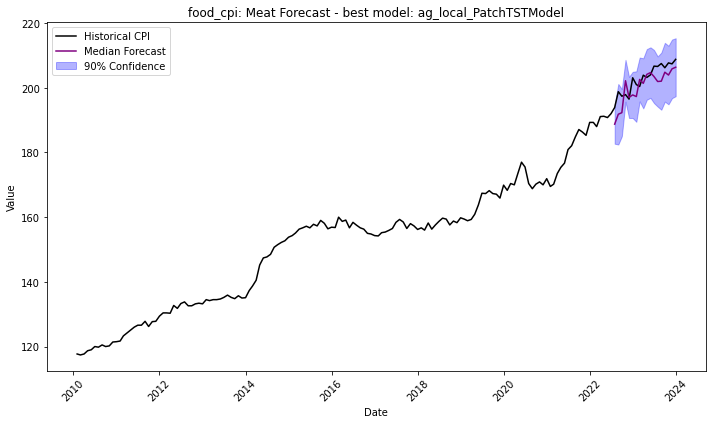

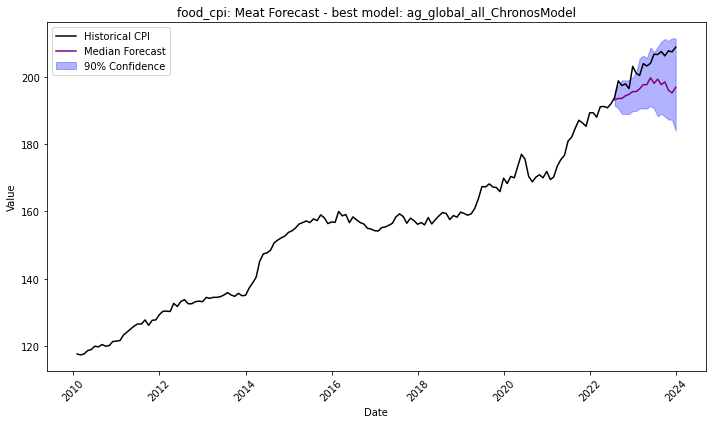

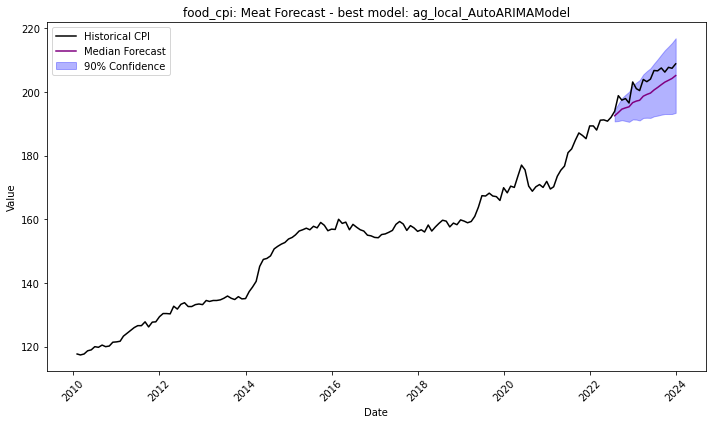

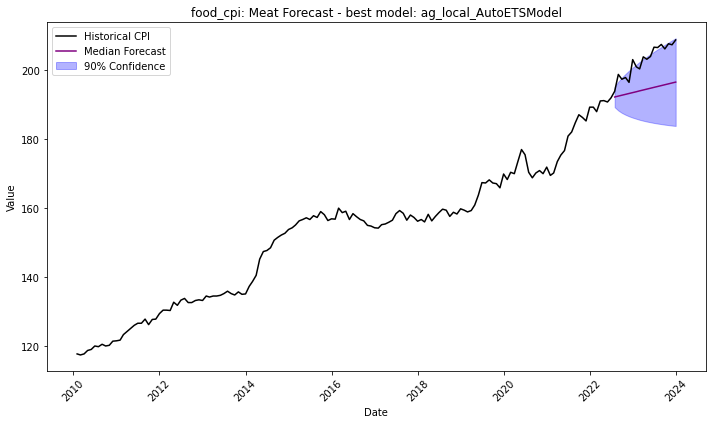

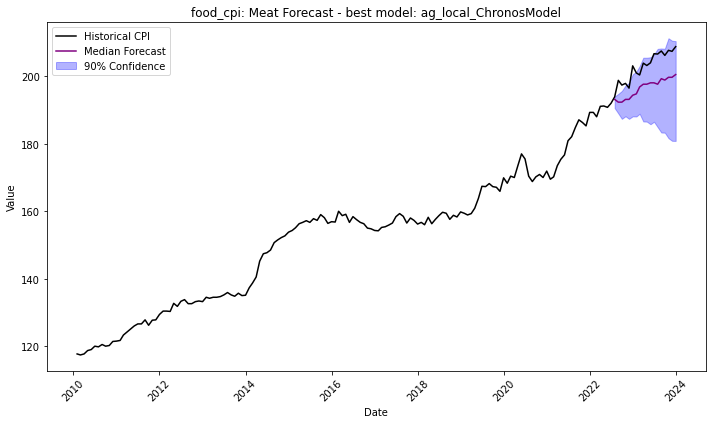

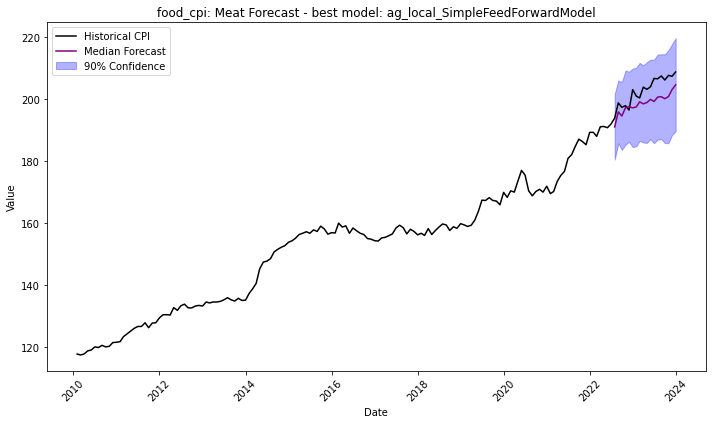

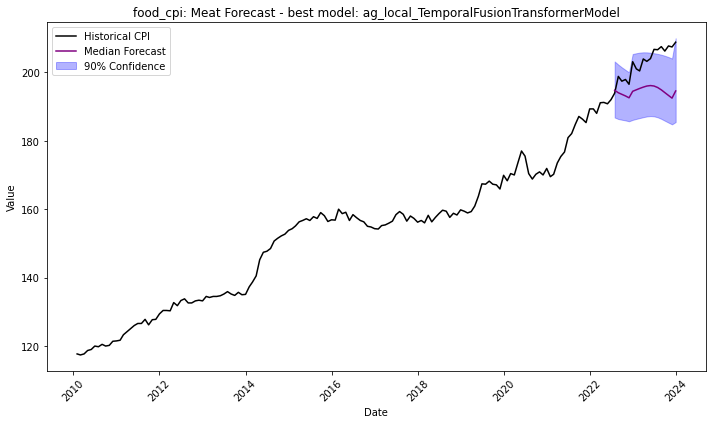

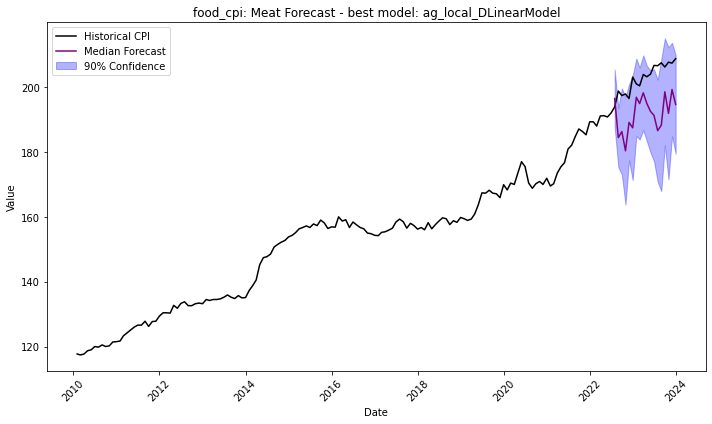

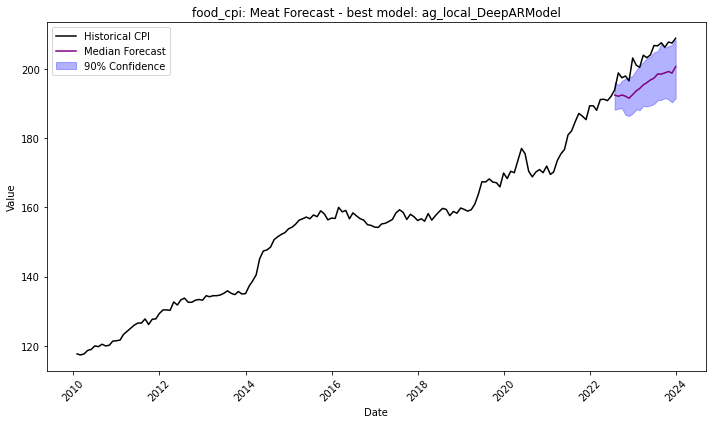

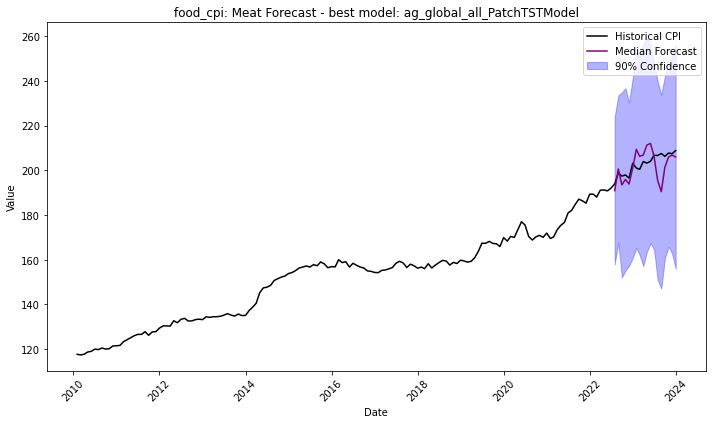

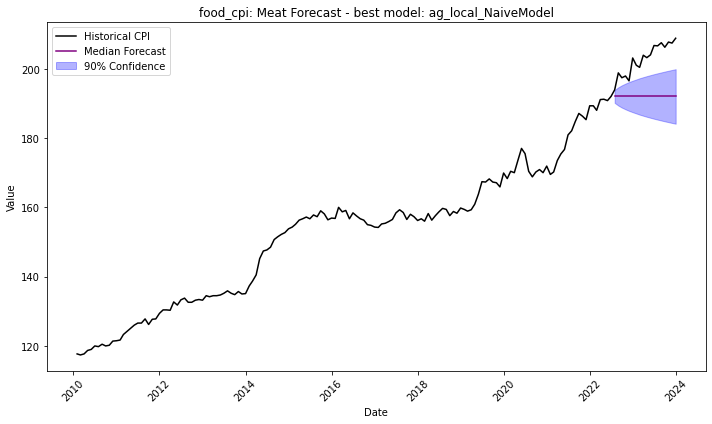

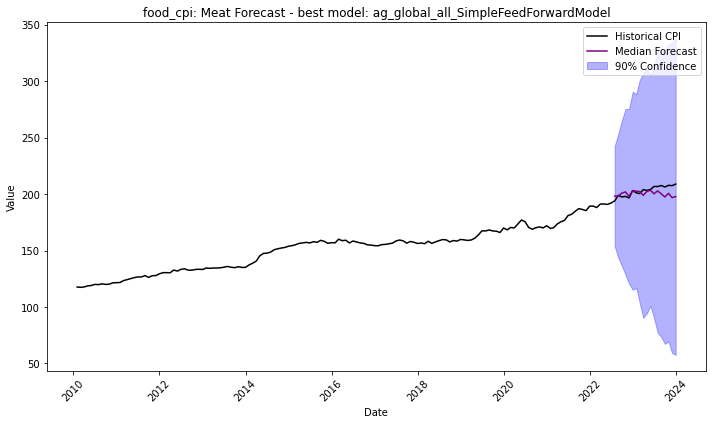

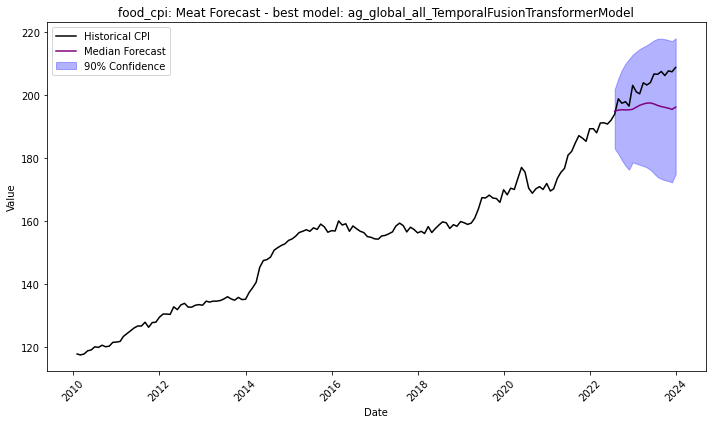

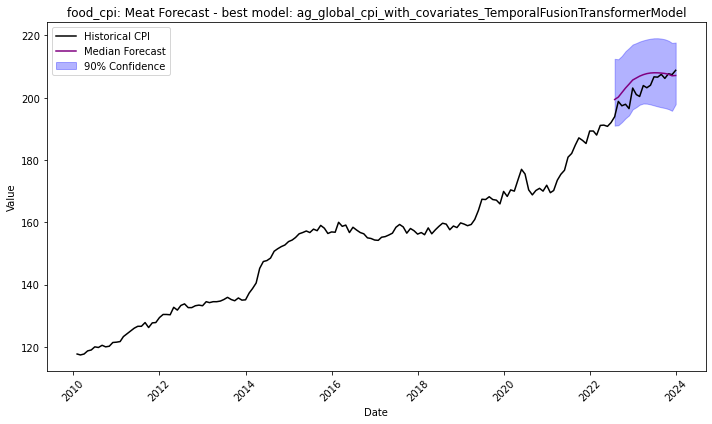

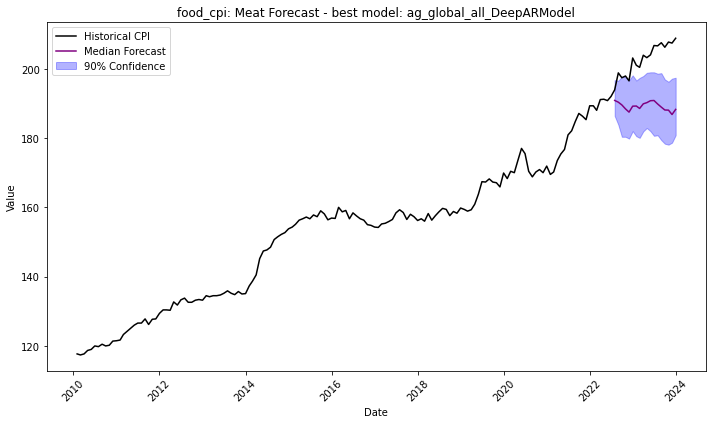

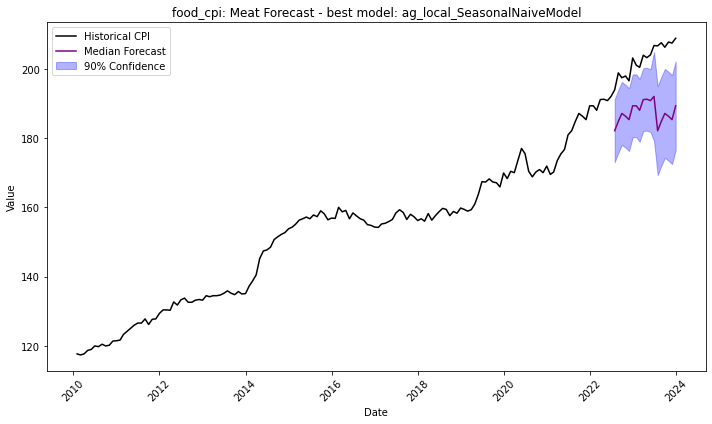

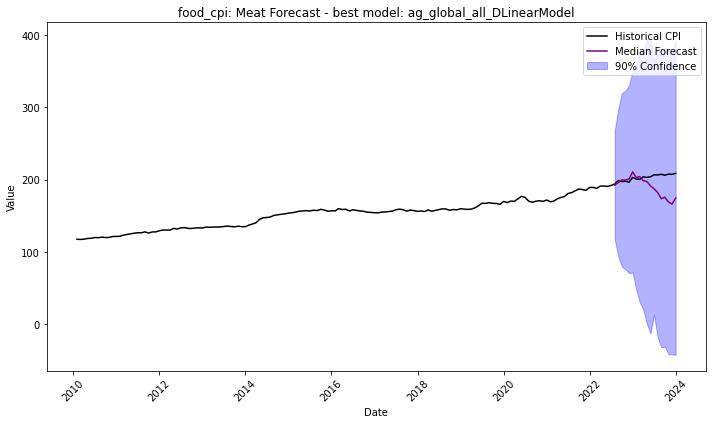

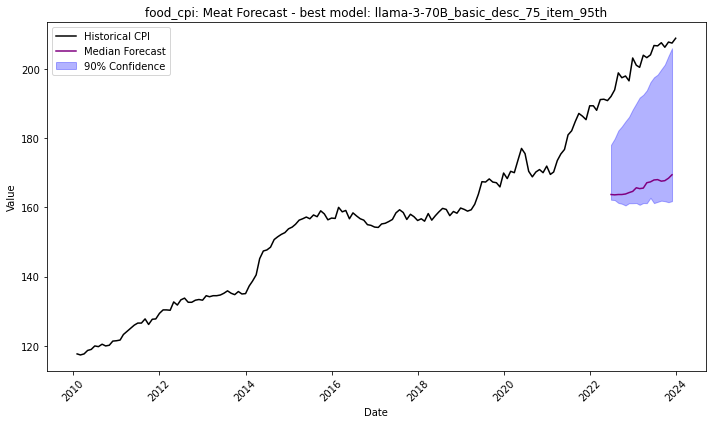

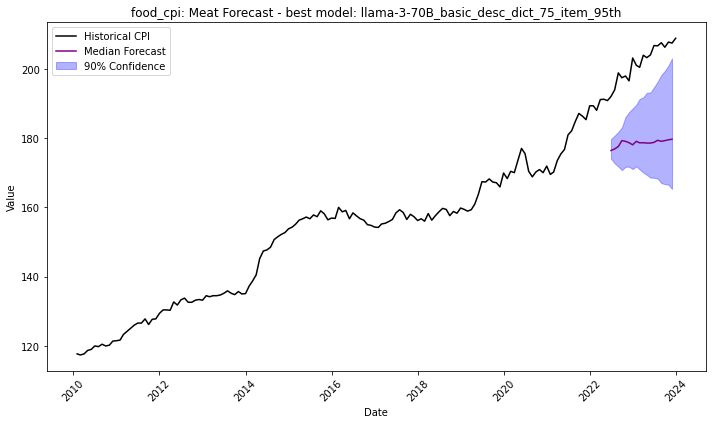

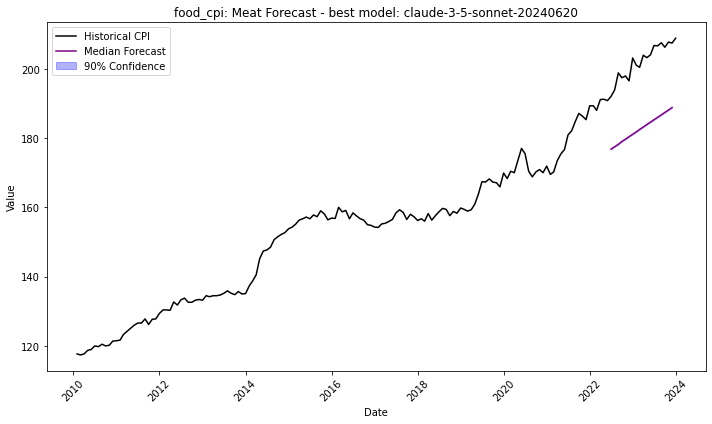

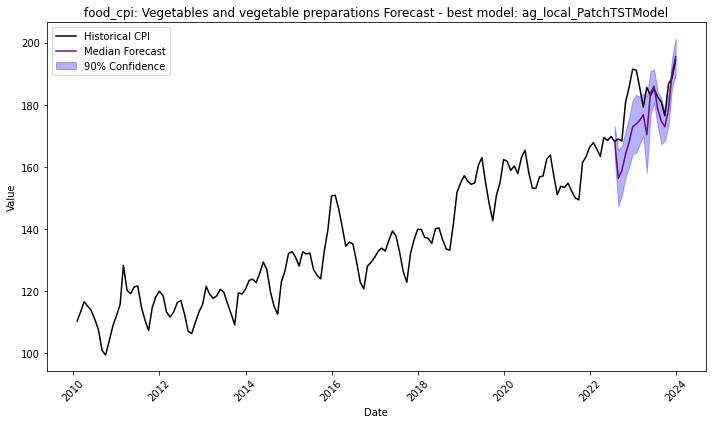

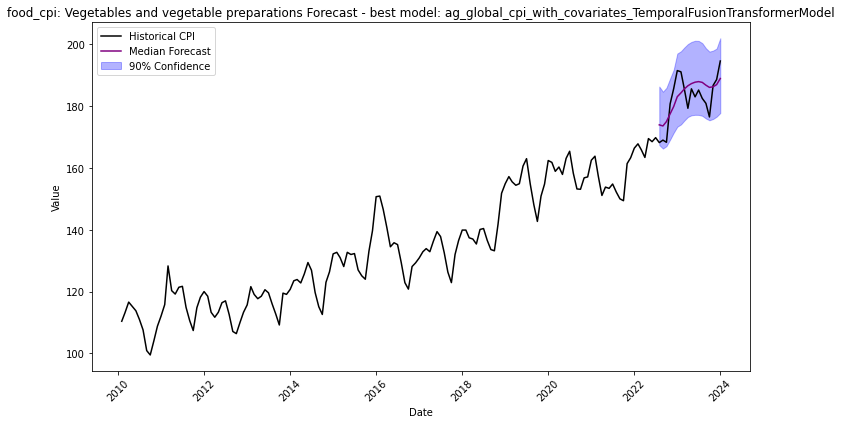

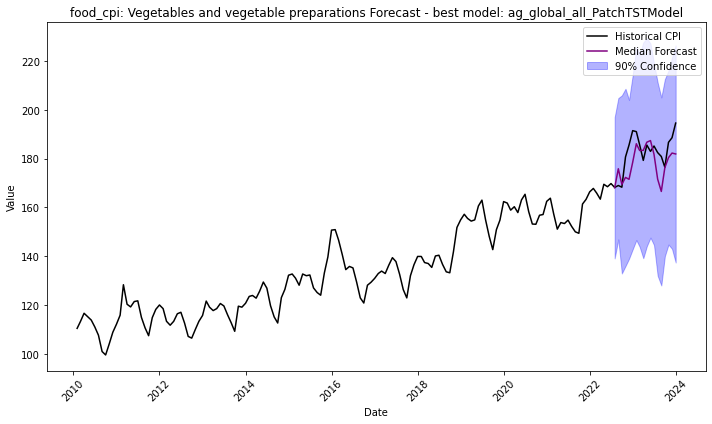

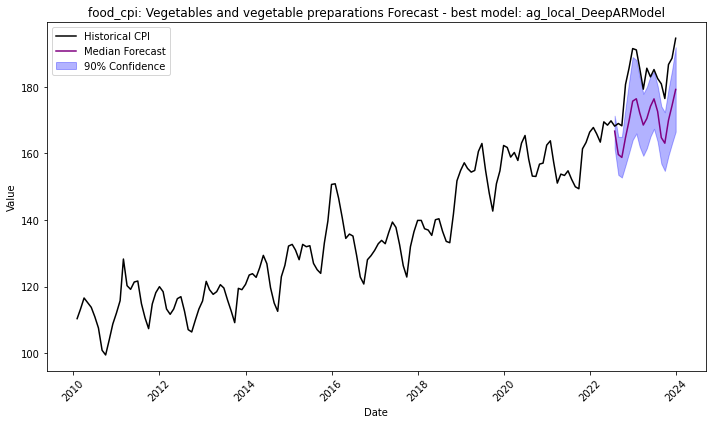

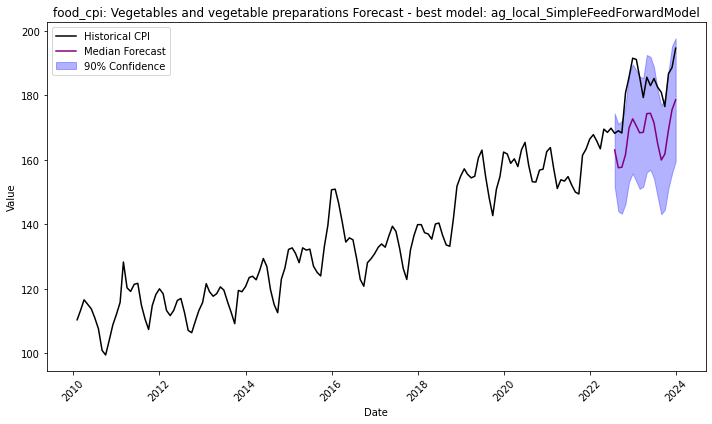

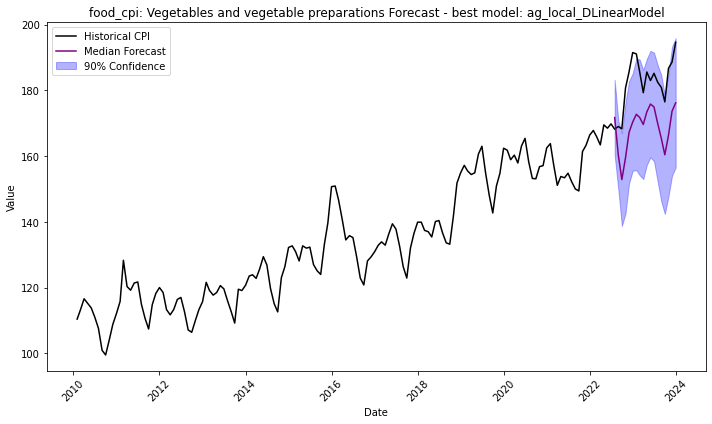

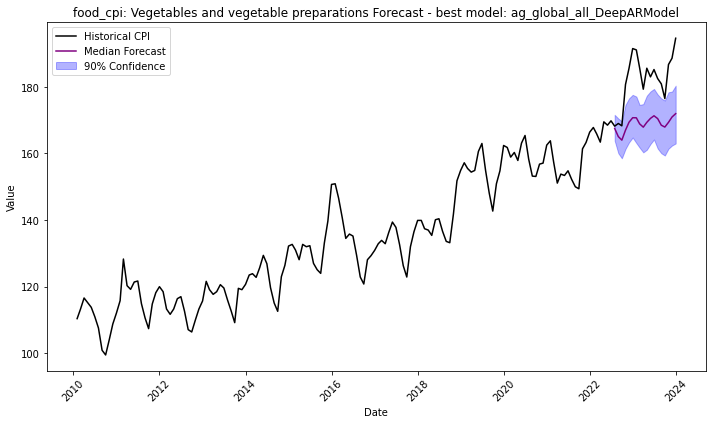

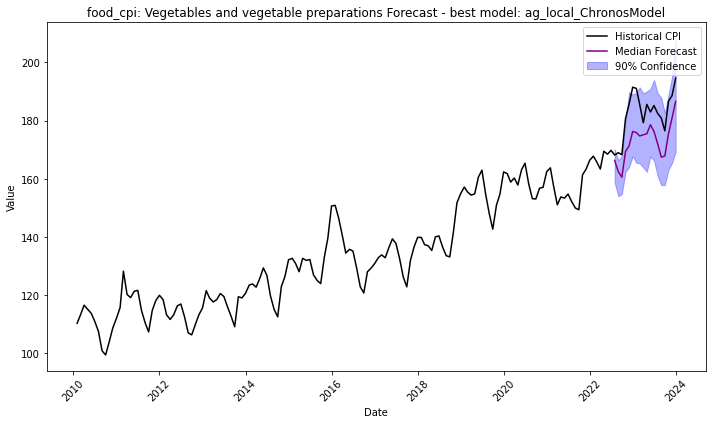

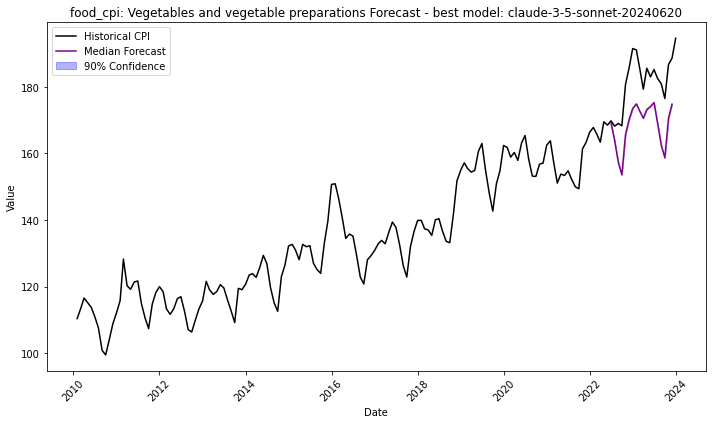

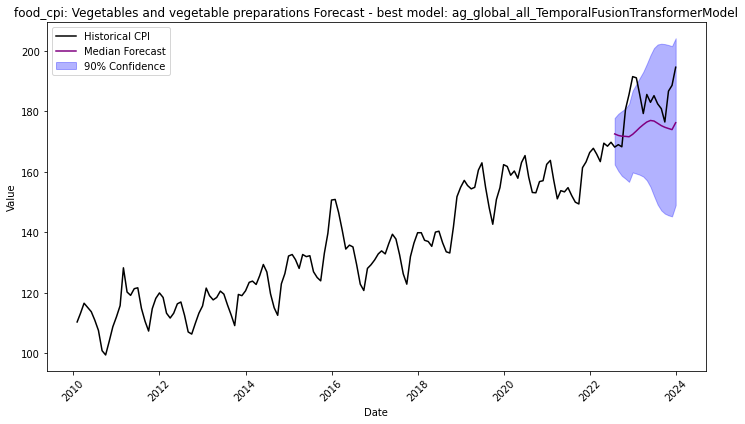

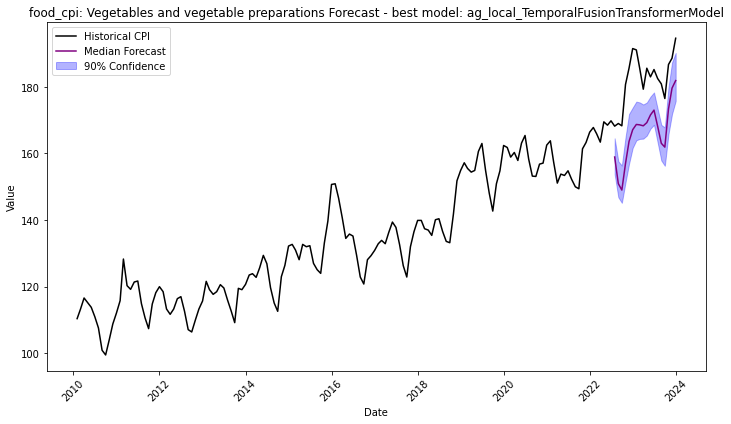

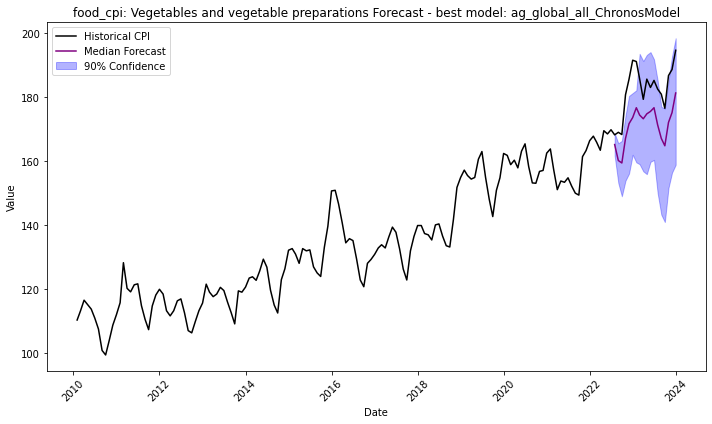

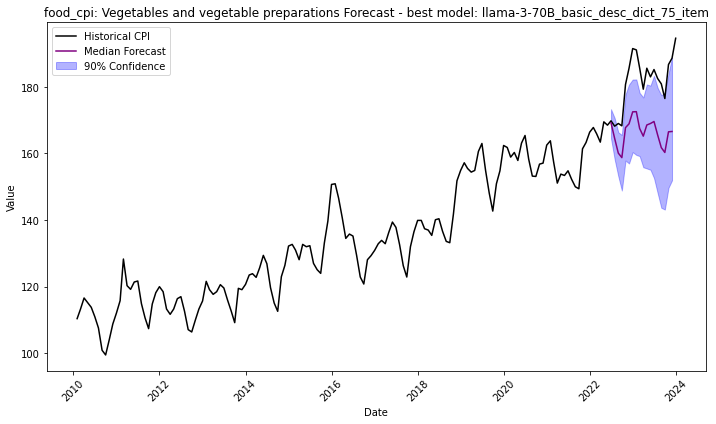

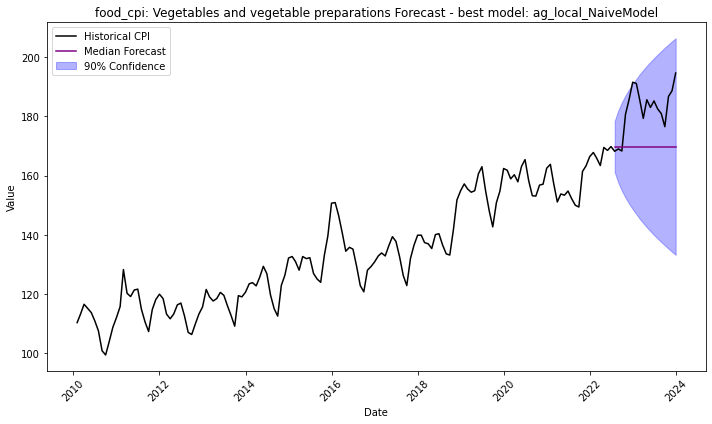

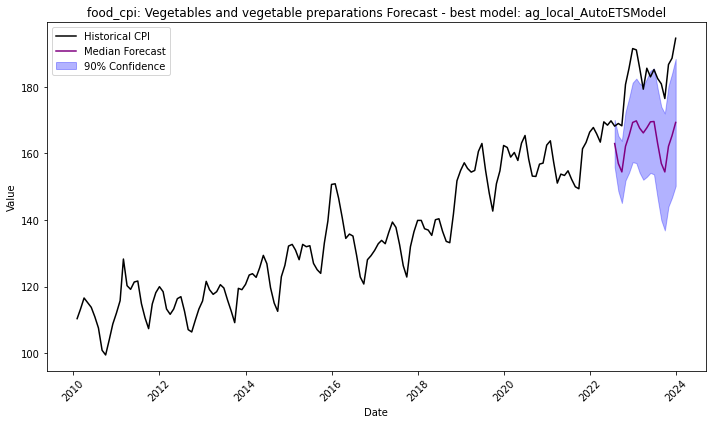

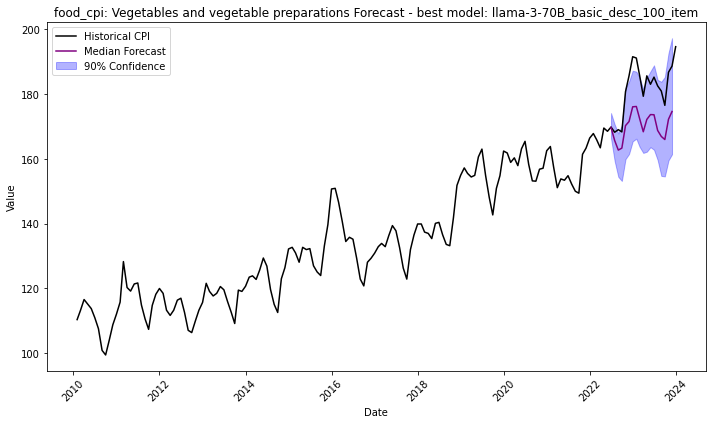

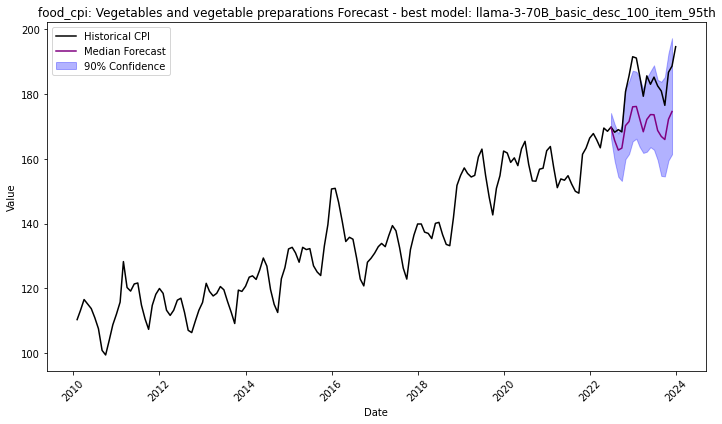

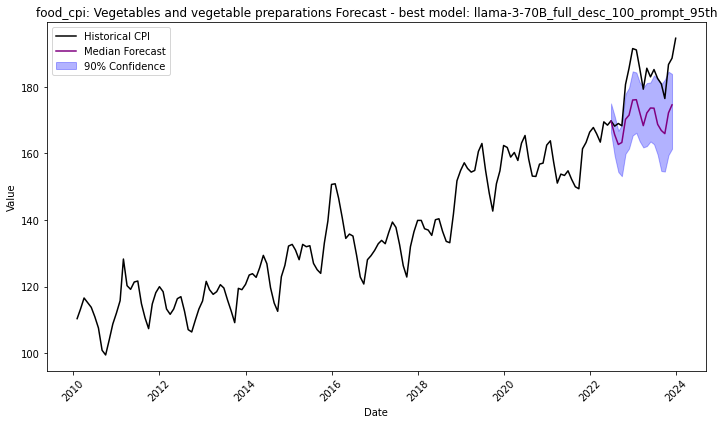

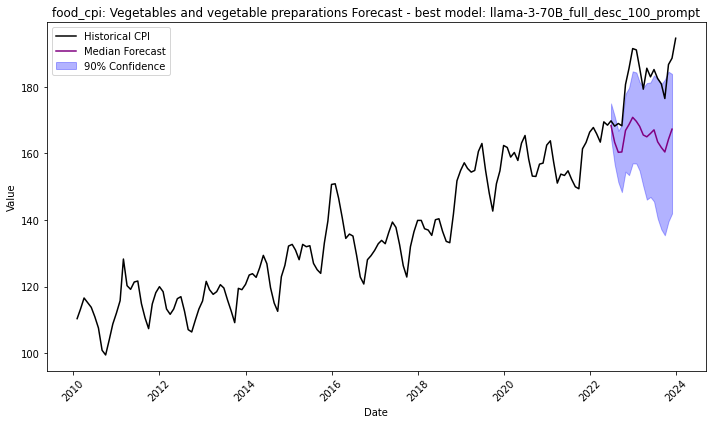

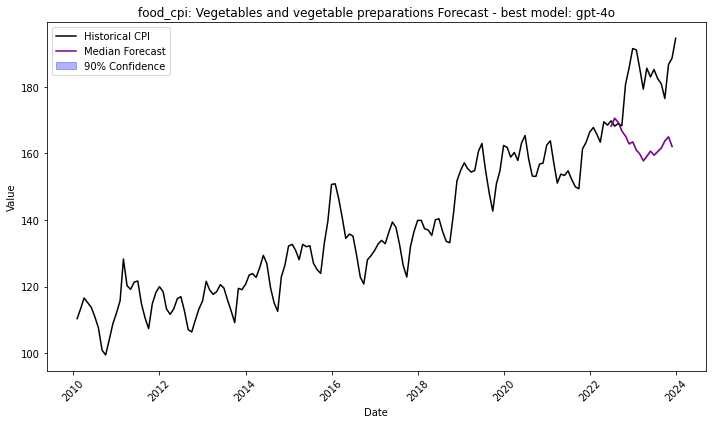

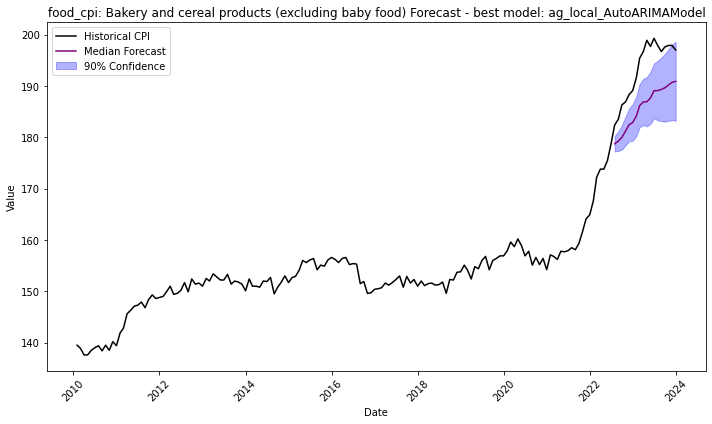

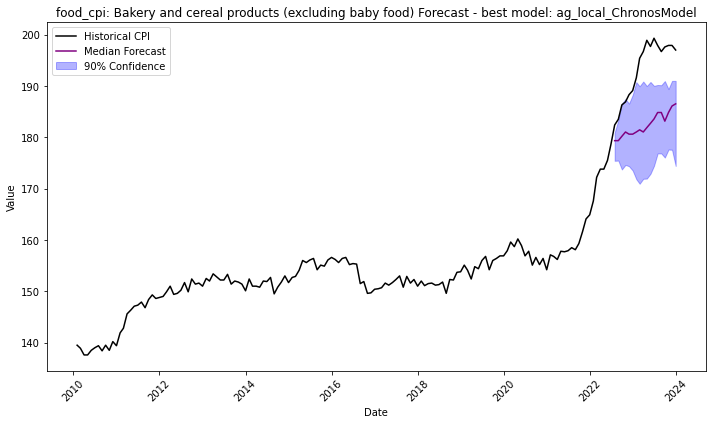

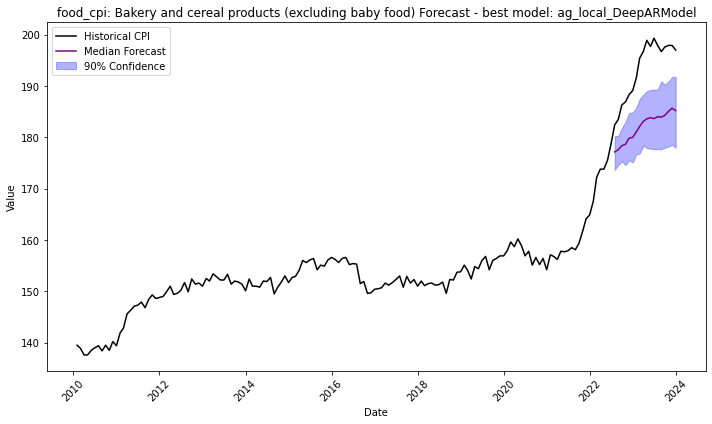

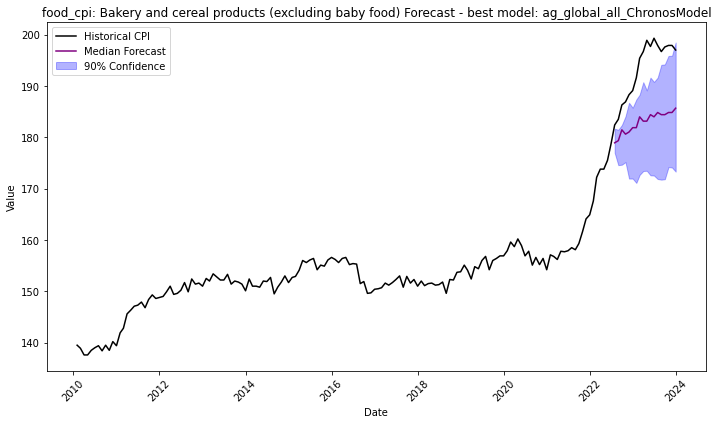

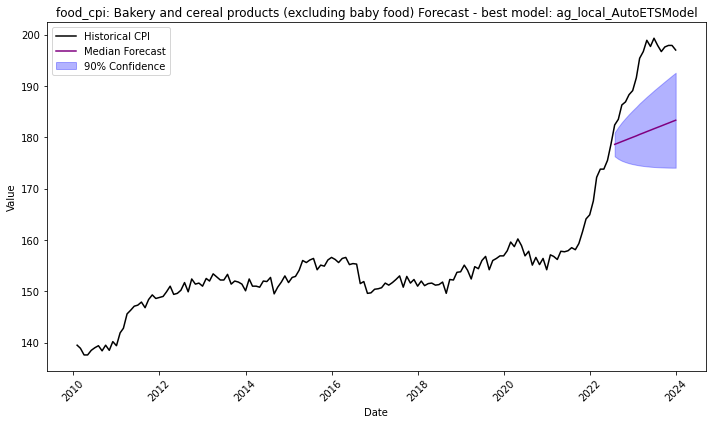

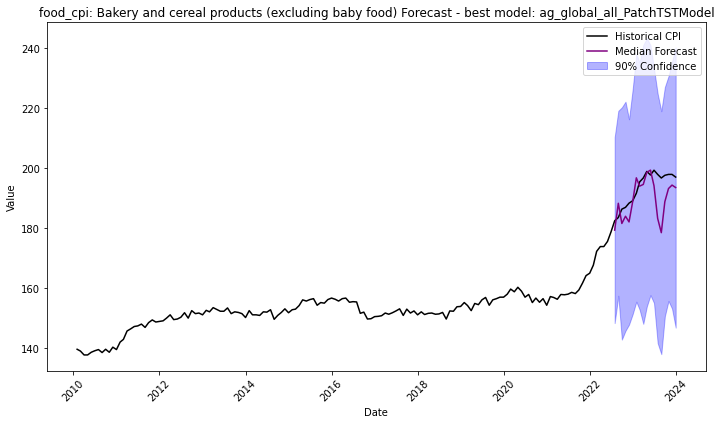

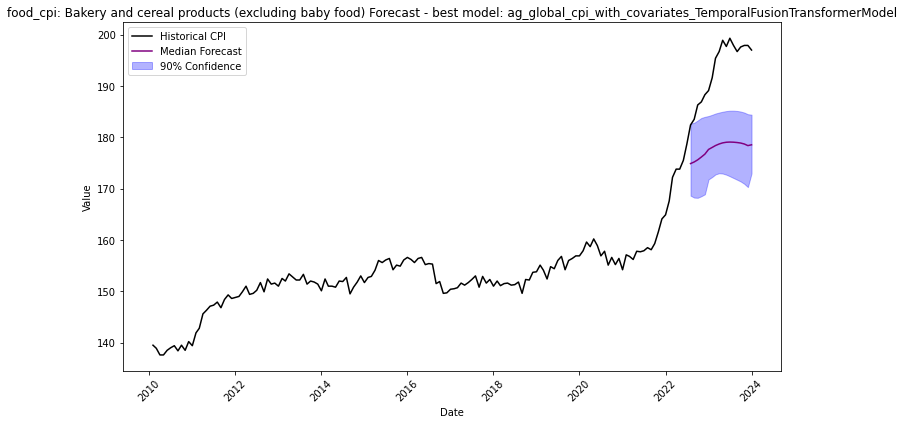

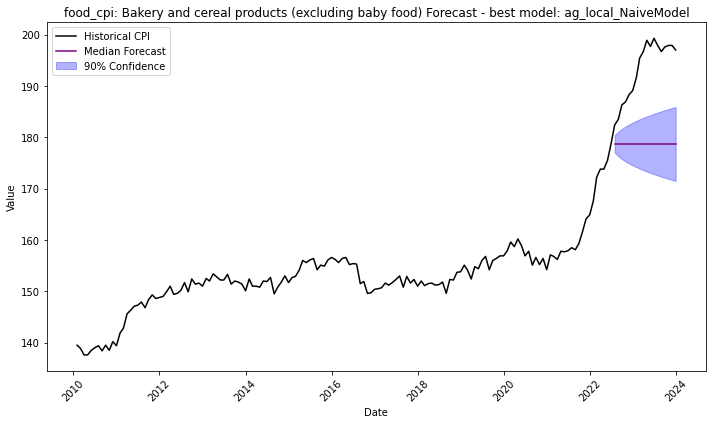

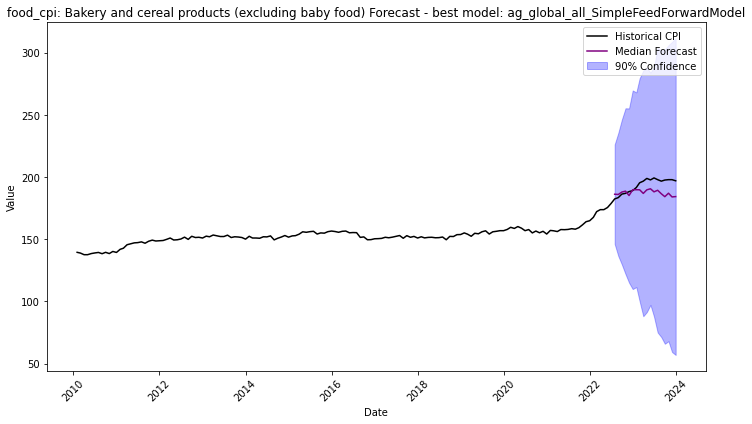

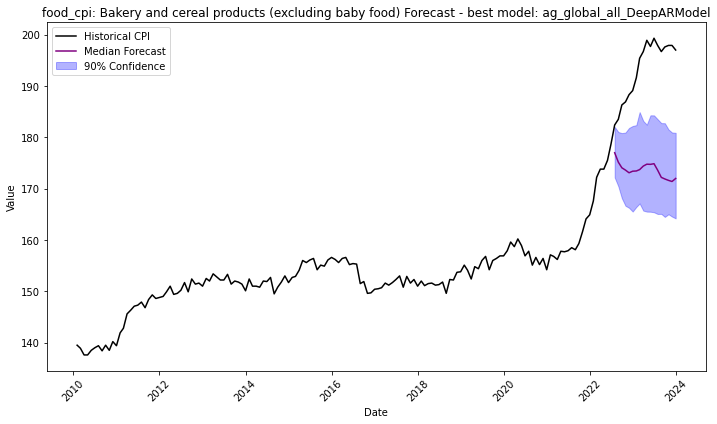

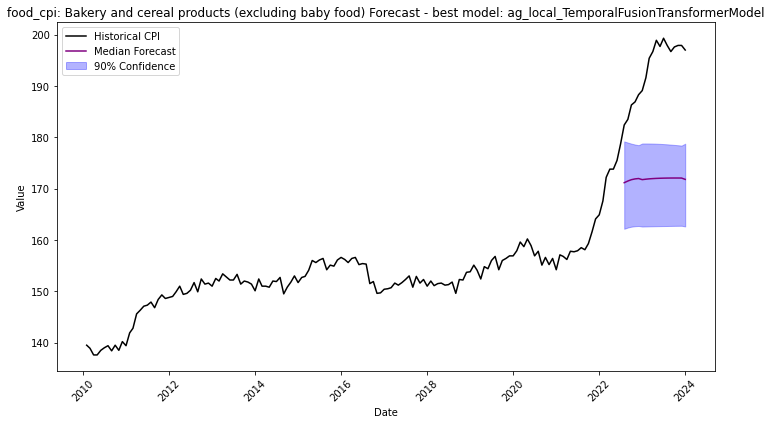

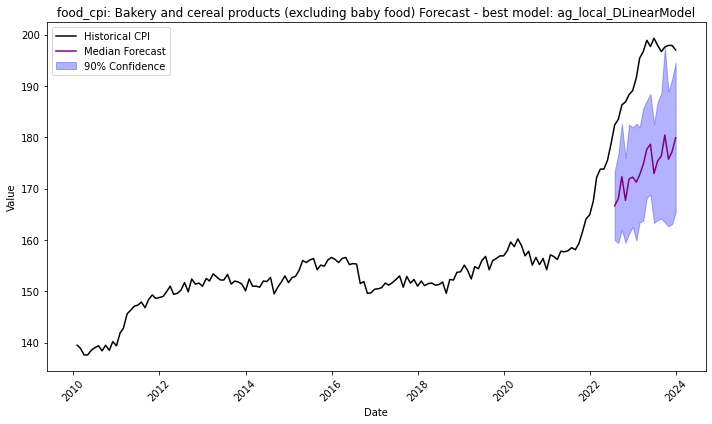

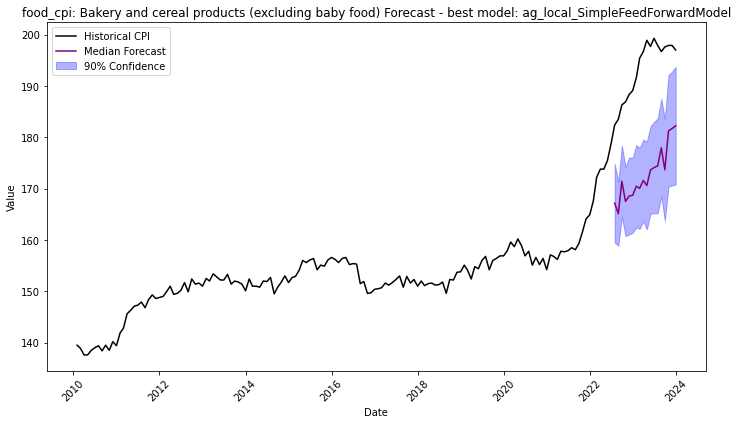

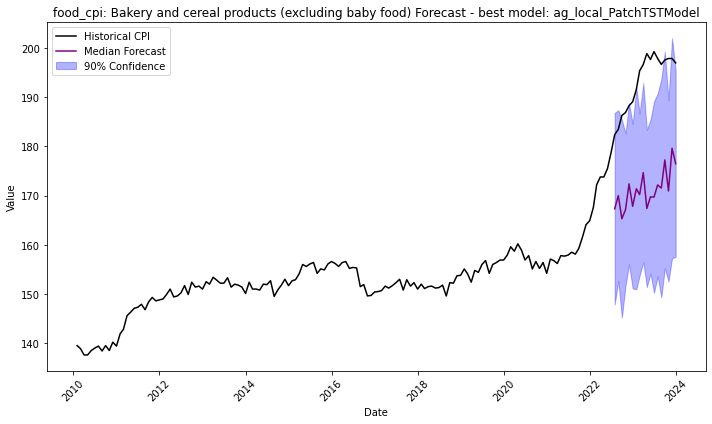

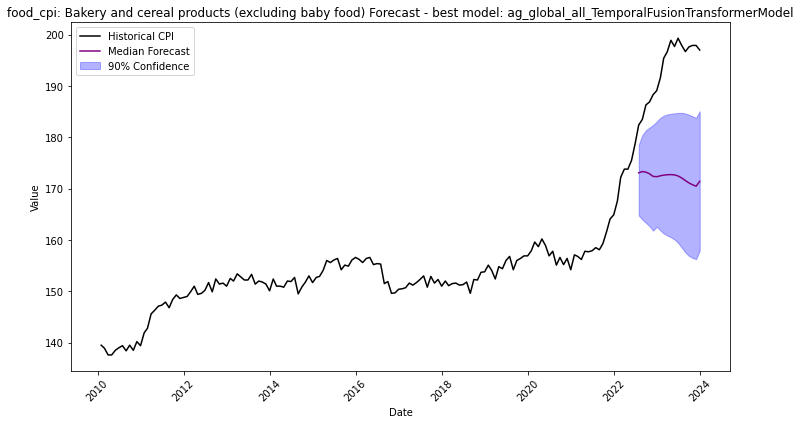

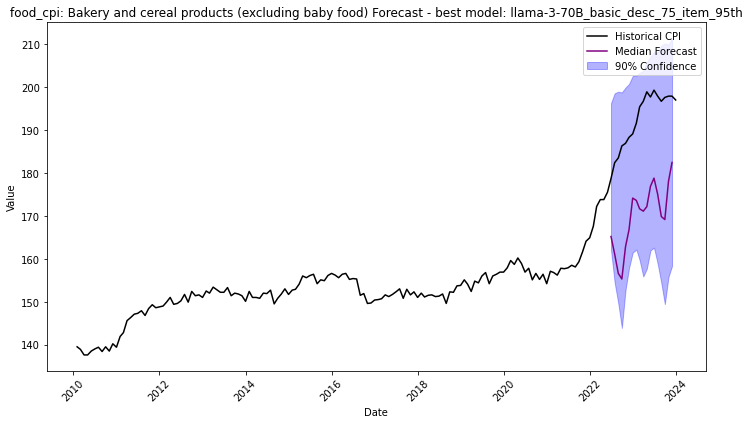

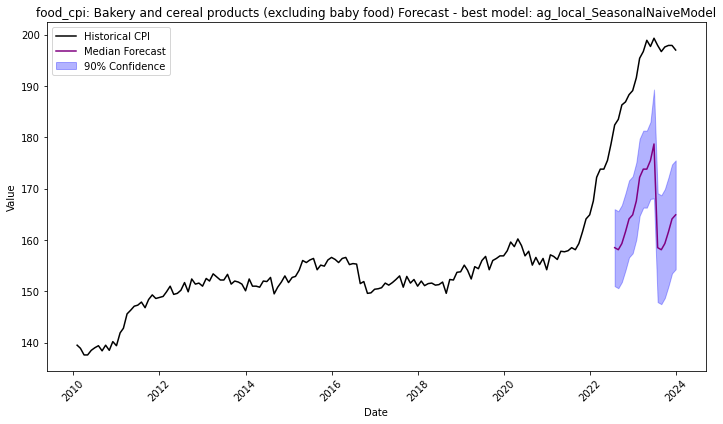

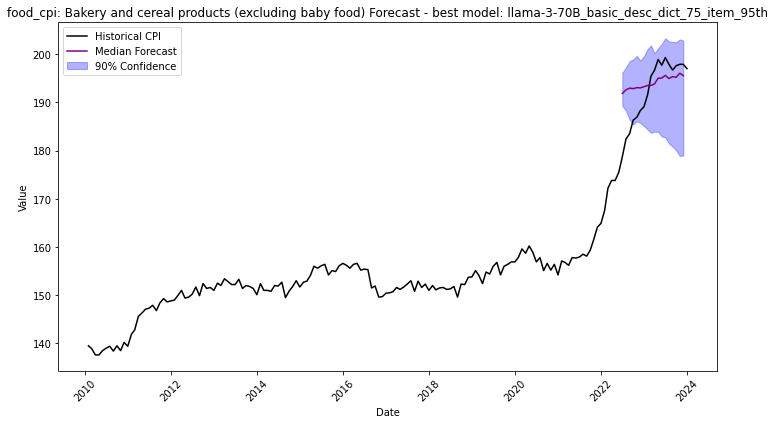

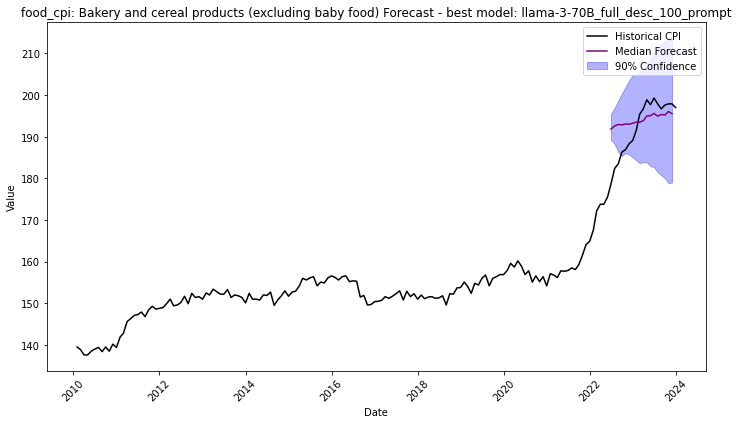

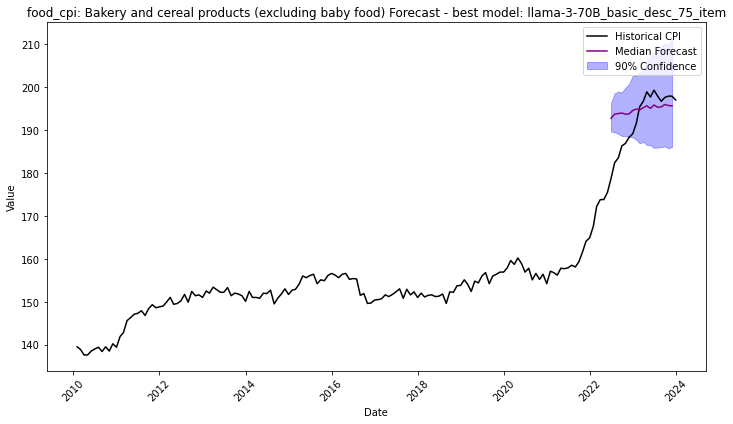

In [292]:
cutoff_dates = report_sim_dates

for index, (category, top_experiment, mean_score, path, scores) in best_results_year_df.iterrows():
    forecast_dfs = []
    for cutoff_date in cutoff_dates:

#         if 'local' in top_experiment or 'global' in top_experiment:
        path_template = path

        file_path = path_template.format(
        exp_test_description=exp_test_description,
        start_year=start_year,
        EXPERIMENT_NAME=top_experiment,
        cutoff_date=cutoff_date,
        category=category
        )

        file_path = file_path.split("'")[1]


#         else:
#             file_path = path
#             print(path)
        
        forecast_csv_path = file_path
        forecast_df = pd.read_csv(forecast_csv_path, index_col=0).iloc[-18:]
        forecast_df.index = pd.to_datetime(forecast_df.index)
        forecast_dfs.append(forecast_df)
        
        
    combined_forecast_df = pd.concat(forecast_dfs, axis=0)
    context_df = foodprice_df.loc[
        (foodprice_df.index > "2010-01-01") & (foodprice_df.index <= cutoff_dates[0])
    ][category]
    
    
    # Ensure cutoff dates and forecast_df.index are aligned with foodprice_df.index
    cutoff_date = pd.to_datetime(cutoff_dates[0]).floor('D')
    last_forecast_date = pd.to_datetime(forecast_df.index.values[-1]).floor('D')

    # Use get_indexer with 'nearest' to find the closest indices
    cutoff_idx = foodprice_df.index.get_indexer([cutoff_date], method='nearest')[0]
    last_forecast_idx = foodprice_df.index.get_indexer([last_forecast_date], method='nearest')[0]

    # Grab the range including one extra row after the last forecast date
    actual_df = foodprice_df.iloc[cutoff_idx: last_forecast_idx + 21][category]

    
    plot_quantile_forecast(
        category,
        context_df,
        forecast_df,
        actual_df,
        cutoff_dates,
        model_name=f"best model: {top_experiment}",
        save_path=file_path.replace('forecasts', 'plots').replace('csv', 'svg'), 
        show_plots=True
    )
    

In [293]:
# Assuming your DataFrame is named 'df' and the column with MAPE lists is 'scores'
# Create a new DataFrame to store the expanded columns for each evaluation window
expanded_df = pd.DataFrame()

# Loop through each row in the original DataFrame
for index, row in mape_df.iterrows():
    mape_list = row['scores']  # Assuming the column with MAPE lists is named 'scores'
    
    # Create a dictionary for the new row
    new_row = {
        'year': row['year'],                # Retain year
        'experiment': row['experiment'],    # Retain experiment name
        'category': row['category'],        # Retain category
        'path': row['path'],                 # Retain path
        'scores': row['scores']                 # Retain path
    }
    
    # Add each evaluation window's score as a new column
    for i, score in enumerate(mape_list):
        new_row['eval_window_'+report_sim_dates[i]] = score
    
    # Append the new row to the expanded DataFrame
    expanded_df = expanded_df.append(new_row, ignore_index=True)
expanded_df


/tmp/ipykernel_32302/1525198995.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_df = expanded_df.append(new_row, ignore_index=True)
/tmp/ipykernel_32302/1525198995.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_df = expanded_df.append(new_row, ignore_index=True)
/tmp/ipykernel_32302/1525198995.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_df = expanded_df.append(new_row, ignore_index=True)
/tmp/ipykernel_32302/1525198995.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_df = expanded_df.append(new_row, ignore_index=True)
/tmp/ipykernel_32302/1525198995.py:23: FutureWarning: The fr

,year,experiment,category,path,scores,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01
0,1986,ag_local_DeepARModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.031693788547086044, 0.035888313787509875, 0...",0.031694,0.035888,0.048189,0.035567
1,1986,ag_local_DeepARModel,food_cpi: Vegetables and vegetable preparations,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.030218199010917175, 0.02872857614087557, 0....",0.030218,0.028729,0.048311,0.068127
2,1986,ag_local_DeepARModel,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.01083870090824001, 0.015306215792048435, 0....",0.010839,0.015306,0.079347,0.058216
3,1986,ag_global_cpi_with_covariates_TemporalFusionTr...,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.04132246447316547, 0.043598893335359386, 0....",0.041322,0.043599,0.075263,0.015931
4,1986,ag_global_cpi_with_covariates_TemporalFusionTr...,food_cpi: Vegetables and vegetable preparations,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.03652536246583645, 0.03959942746316373, 0.0...",0.036525,0.039599,0.036214,0.026460
...,...,...,...,...,...,...,...,...,...
79,1986,claude-3-5-sonnet-20240620,food_cpi: Vegetables and vegetable preparations,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.05232504355246978, 0.03662987807431451, 0.0...",0.052325,0.036630,0.060128,0.069749
80,1986,claude-3-5-sonnet-20240620,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.06670842818588801, 0.15715093742570072, 0.0...",0.066708,0.157151,0.089657,0.024435
81,1986,gemini-1.5-pro,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.08281669635541704, 0.0667967145255106, 0.14...",0.082817,0.066797,0.141958,0.116315
82,1986,gemini-1.5-pro,food_cpi: Vegetables and vegetable preparations,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.0891783183671817, 0.029917592446578496, 0.0...",0.089178,0.029918,0.052680,0.298337


In [304]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category(df, category):

    # Assuming `expanded_df` is the DataFrame from the previous step with columns for each evaluation window
    #Set the index to 'experiment' for better visualization
    df.set_index('experiment', inplace=True)
    
    # Select only the columns related to evaluation windows (eval_window_0, eval_window_1, ...)
    eval_columns = [col for col in df.columns if 'eval_window_' in col]

    # Create the heatmap using seaborn
    plt.figure(figsize=(15, 12))  # Adjust the size of the heatmap as needed
    sns.heatmap(df[eval_columns], annot=True, cmap='coolwarm', linewidths=0.5)

    # Set the title and labels
    plt.title(f'Heatmap of Evaluation Window Scores For {category} Across Experiments', fontsize=16)
    plt.xlabel('Evaluation Windows')
    plt.ylabel('Experiment')

    # Show the heatmap
    plt.show()

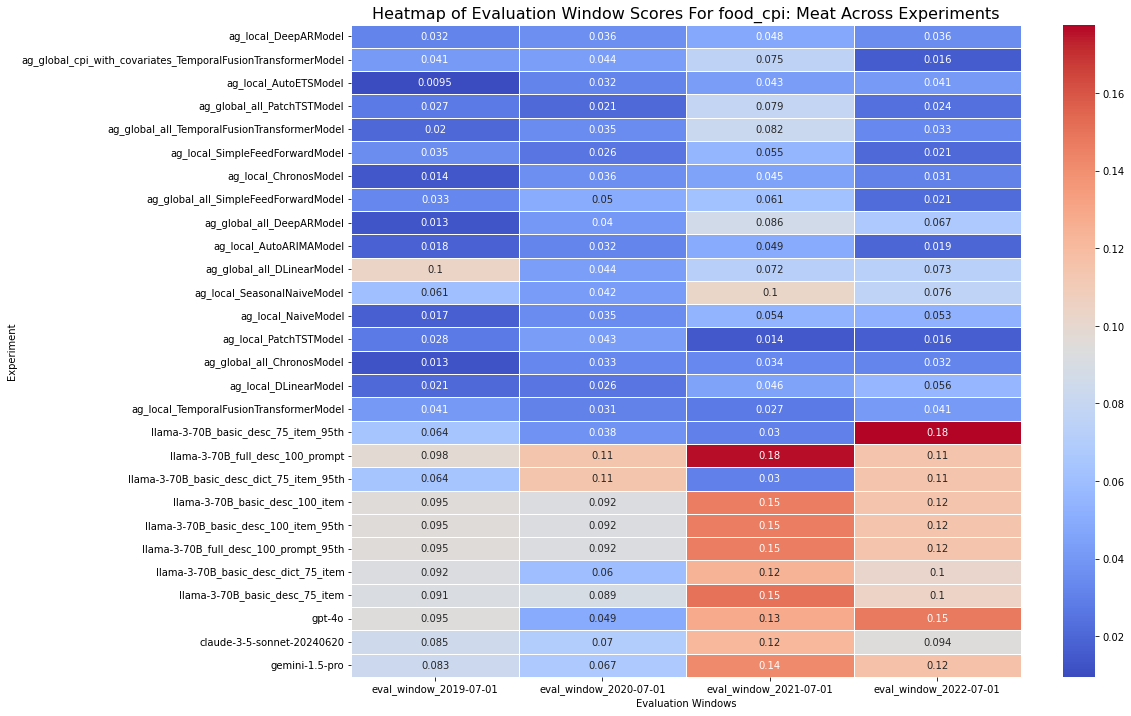

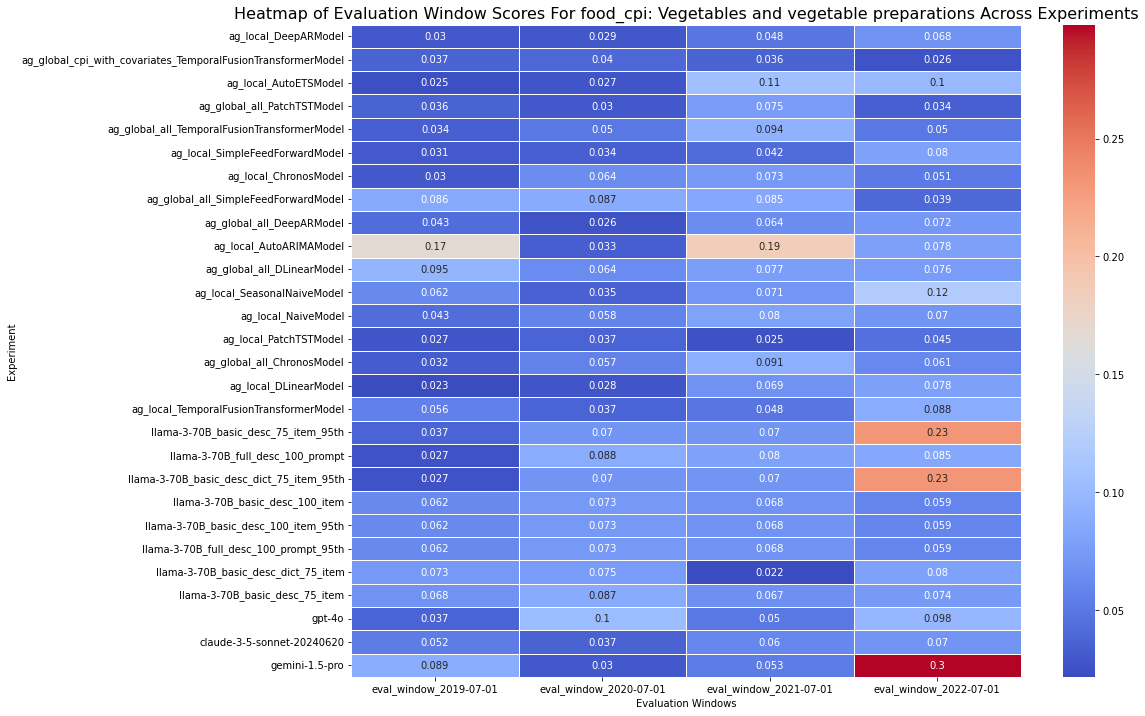

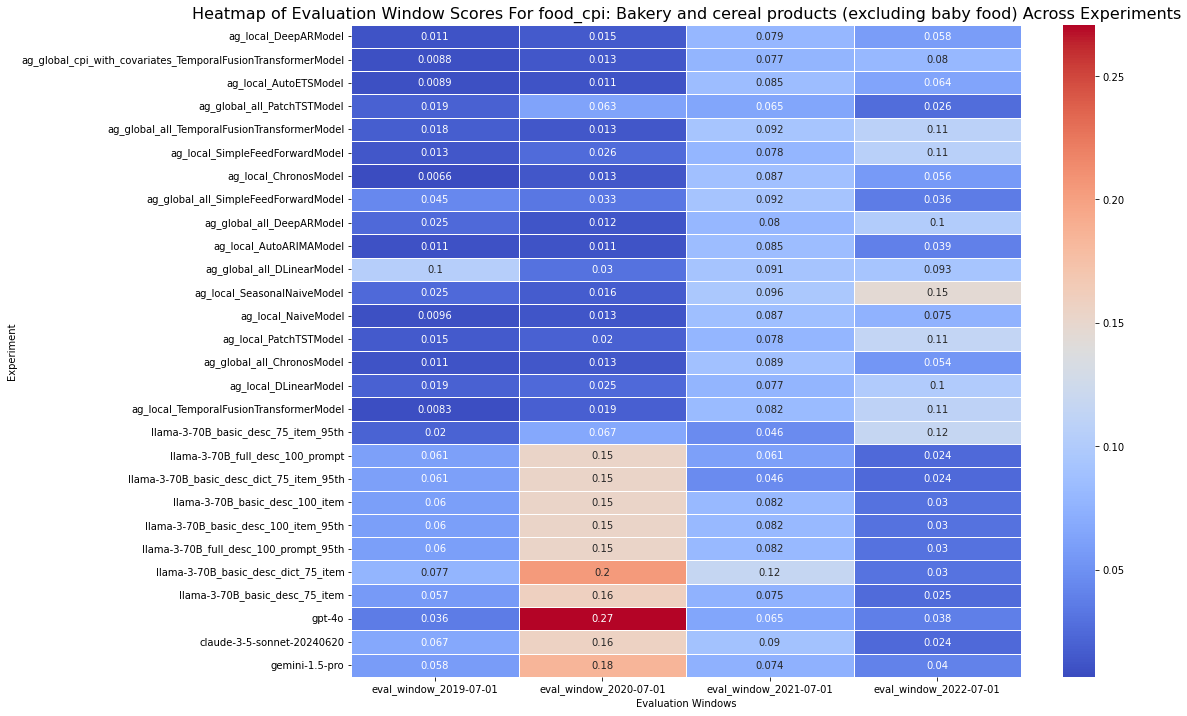

In [305]:
for category in target_categories:
    df_filt = expanded_df.loc[expanded_df['category']==category]
    plot_category(df_filt, category)

In [298]:
df_filt = expanded_df.loc[expanded_df['category']==target_categories[0]]
df_filt

,year,experiment,category,path,scores,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01
0,1986,ag_local_DeepARModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.031693788547086044, 0.035888313787509875, 0...",0.031694,0.035888,0.048189,0.035567
3,1986,ag_global_cpi_with_covariates_TemporalFusionTr...,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.04132246447316547, 0.043598893335359386, 0....",0.041322,0.043599,0.075263,0.015931
6,1986,ag_local_AutoETSModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.009480868957196346, 0.031814290261905485, 0...",0.009481,0.031814,0.042633,0.041206
9,1986,ag_global_all_PatchTSTModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.02749604768796501, 0.021160654793141727, 0....",0.027496,0.021161,0.079051,0.023866
12,1986,ag_global_all_TemporalFusionTransformerModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.02030729242147746, 0.034793676970986565, 0....",0.020307,0.034794,0.081834,0.033216
15,1986,ag_local_SimpleFeedForwardModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.03547136872704303, 0.025728140125629153, 0....",0.035471,0.025728,0.055202,0.020662
18,1986,ag_local_ChronosModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.013654055082659412, 0.03615352902328766, 0....",0.013654,0.036154,0.045035,0.030936
21,1986,ag_global_all_SimpleFeedForwardModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.03255603520510103, 0.049973150401609365, 0....",0.032556,0.049973,0.061456,0.021439
24,1986,ag_global_all_DeepARModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.01286383339076082, 0.040277819856419525, 0....",0.012864,0.040278,0.085990,0.066850
27,1986,ag_local_AutoARIMAModel,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.017687201591241826, 0.032269028215397885, 0...",0.017687,0.032269,0.049346,0.019477
